In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astro_models
from astropy import constants as const

### Tentative Model for LTT9779b

Text(0, 0.5, 'Normalized Flux')

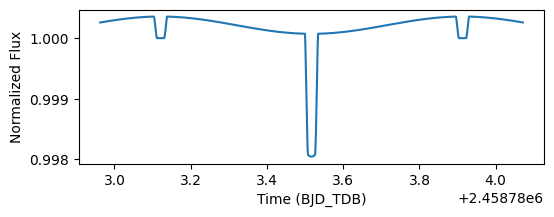

In [10]:
t0   = 2458783.51684 #transit time
per  = 0.7920520     #Orbital period.
rp   = 0.0455        #Planet radius (in units of stellar radii).
a    = 3.877         #Semi-major axis (in units of stellar radii).
inc  = 76.39         #Orbital inclination (in degrees).
ecosw= 0.0           #Eccentricity multiplied by the cosine of the longitude of periastron (value between -1 and 1).
esinw= 0.0           #Eccentricity multiplied by the sine of the longitude of periastron (value between -1 and 1).
q1   = 0.01          #Limb darkening coefficient 1, parametrized to range between 0 and 1.
q2   = 0.01          #Limb darkening coefficient 2, parametrized to range between 0 and 1.
fp   = 0.000358      #Planet-to-star flux ratio.
A    = 0.4           #Amplitude of the first-order cosine term.
B    = 0.0001        #Amplitude of the first-order sine term.
C    = 0.0           #(optional): Amplitude of the second-order cosine term. Default=0.
D    = 0.0           #(optional): Amplitude of the second-order sine term. Default=0.
r2   = None          #(optional): Planet radius along sub-stellar axis (in units of stellar radii). Default=None.
r2off= None          #(optional): Angle to the elongated axis with respectto the sub-stellar axis (in degrees). Default=None.

time = np.linspace(t0-0.7*per, t0+0.7*per, 1000) #Array of times at which to calculate the model.
flux = astro_models.ideal_lightcurve(time, t0, per, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B)

plt.figure(figsize=(6,2))
plt.plot(time,flux)
plt.xlabel('Time (BJD_TDB)')
plt.ylabel('Normalized Flux')


### Constraining Tday and Tnight from the phase curve
only valid for C=D=0 for now

In [11]:
wav  = 4.5*1e-6 #average wavelength 
tstar_bs = 5443

tday = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_bs))-1)/(fp/rp**2)))**-1
print('T_day:', np.round(tday, 2), 'K')
        
tnight = const.h.value*const.c.value/(const.k_B.value*wav)*(np.log(1+(np.exp(const.h.value*const.c.value/(const.k_B.value*wav*tstar_bs))-1)/(fp*(1-2*A)/rp**2)))**-1
print('T_night:', np.round(tnight, 2), 'K')


T_day: 1851.62 K
T_night: 1004.58 K


### Constraining Bond Albedo and Heat Recirculation Efficiency
a la Schwartz and Cowan 2015, might have to double check math...

In [29]:
def heat_recirc(tday, tnight):
    upper = 2*tnight**4
    lower = 3*((5*tnight**4/12)+(tday**4/4))
    return upper/lower

def bond_alb(tday, tnight, epsilon, T0):
    return 1-((4*tnight**4)/(epsilon*T0**4))

def Tirr(tstar_bs, a):
    return tstar_bs*np.sqrt(1/a)

T0 = Tirr(tstar_bs, a)
print('Irradiation Temperature T0:', round(T0,2), 'K')

epsilon = heat_recirc(tday, tnight)
print('heat recirculation efficiency [0,1]:', round(epsilon,4))

A_b = bond_alb(tday, tnight, epsilon, T0)
print('Bond Albedo [0,1]:', round(A_b,2))

Irradiation Temperature T0: 2764.33 K
heat recirculation efficiency [0,1]: 0.2019
Bond Albedo [0,1]: 0.65


### Make Thermal Map of Exoplanet

Text(0, 0.5, 'latitude')

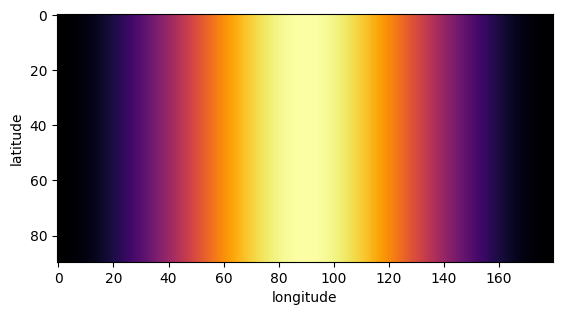

In [63]:
# transform phase curve coeff into fourier series coeff
F_0 = 1-A-C
C_1, D_1 = A, B
C_2, D_2 = C, D

# transform to map coeff
A_0 = F_0/2
A_1, B_1 = 2*C_1/np.pi, -2*D_1/np.pi
A_2, B_2 = 3*C_2/2, -3*D_2/2 

# longitudinal brightness
longitude = np.linspace(-np.pi, np.pi, 180)
lon_brigh = A_0 + A_1*np.cos(longitude) + A_2*np.cos(2*longitude) + B_1*np.sin(longitude) + B_2*np.sin(2*longitude)

# lon-lat map
latitude  = np.linspace(-np.pi/2, np.pi/2, 90)
latitude  = np.expand_dims(latitude, axis=1)
lon_map   = np.tile(lon_brigh, (90,1))

# double-check math... 
brightmap = (3/4)*lon_map*np.cos(latitude)

plt.imshow(lon_map, cmap='inferno')
plt.title('Brightness ')
plt.xlabel('longitude')
plt.ylabel('latitude')

plt.imshow(lon_map, cmap='inferno')
plt.xlabel('longitude')
plt.ylabel('latitude')